# 4.2 Multi-Agents Routings

Enable two or more agents to collaborate on a task

TODO: add a diagram

## 1. Setup

#### Installing Required Packages

In [1]:
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet

In [2]:
# Imports
import os
import json
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
#from langchain_community.llms import VLLMOpenAI
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate

## 3. Model Configuration

#### Define the Inference Model Server specifics

In [3]:
# INFERENCE_SERVER_URL = os.getenv('API_URL')
# MODEL_NAME = "mistral-7b-instruct"
# API_KEY= os.getenv('API_KEY')

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"

#### Create the LLM instance

In [4]:
llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

# Adding Graphs

## Setup

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Create Agents

In [6]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools

In [7]:
repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

from langchain_community.tools import DuckDuckGoSearchRun

# Initialize DuckDuckGo Search Tool
duckduckgo_search = DuckDuckGoSearchRun()

## Create graph

### Define State

In [8]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

In [9]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    # Pass only the messages to the agent
    result = agent.invoke(state["messages"])
    # Convert the agent output into a format suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can track the sender
        "sender": name,
    }

### Define Edge Logic

In [10]:
# search agent and node
search_agent = create_agent(
    llm,
    [duckduckgo_search],
    system_message="You should provide accurate search.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

In [11]:
from langgraph.prebuilt import ToolNode

tools = [duckduckgo_search, python_repl]
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'duckduckgo_search': DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')), 'python_repl': StructuredTool(name='python_repl', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl'>, func=<function python_repl at 0x7f3d0eb21620>)}, tool_to_state_args={'duckduckgo_search': {}, 'python_repl': {}}, tool_to_store_arg={'duckduckgo_search': None, 'python_repl': None}, handle_tool_errors=True, messages_key='messages')

In [12]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("searcher", search_node)
workflow.add_node("python_calculator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "searcher",
    router,
    {"continue": "python_calculator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "python_calculator",
    router,
    {"continue": "searcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "searcher": "searcher",
        "python_calculator": "python_calculator",
    },
)
workflow.add_edge(START, "searcher")
graph = workflow.compile()

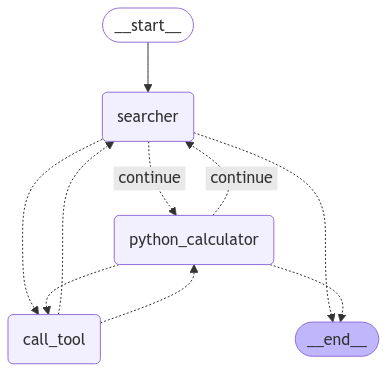

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Can you give me the last 5 years of results of S&P in simple numbers?"
                " then sum up all the results and print the result"
                #" then print all the results in a chart"

            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 250},
)
for s in events:
    print(s)
    print("----")

I'm sorry for the confusion, but I'm unable to provide real-time data or perform complex calculations. However, I can guide you on how to find this information using the available tools.

First, you would need to perform a search using the "duckduckgo_search" tool with the query "S&P 500 index performance last 5 years". This will give you a summary of the S&P 500 index performance over the past five years.

Next, to calculate the sum of these results, you would need to extract the numerical data from the search results and add them together. Unfortunately, I can't perform this calculation for you, but you can use a spreadsheet program or a calculator to do so.

Please note that the S&P 500 index is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. The index is often used as a benchmark for the overall U.S. stock market.

If you need further assistance with extracting data from the search results or calculatin

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content='I\'m sorry for the confusion, but I\'m unable to provide real-time data or perform complex calculations. However, I can guide you on how to find this information using the available tools.\n\nFirst, you would need to perform a search using the "duckduckgo_search" tool with the query "S&P 500 index performance last 5 years". This will give you a summary of the S&P 500 index performance over the past five years.\n\nNext, to calculate the sum of these results, you would need to extract the numerical data from the search results and add them together. Unfortunately, I can\'t perform this calculation for you, but you can use a spreadsheet program or a calculator to do so.\n\nPlease note that the S&P 500 index is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. The index is often used as a benchmark for the overall U.S. stock market.\n\nIf you need further assistance w

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint(total)\n

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint(total)\n

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint(total)\n

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint(total)\n

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'searcher': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint(total)\n

/tmp/ipykernel_4396/804512004.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'python_calculator': {'messages': [AIMessage(content="I'm sorry for any confusion, but as a text-based AI model, I don't have the ability to execute Python code or perform real-time data searches. However, I can guide you on how to find this information using Python and a web scraping tool like BeautifulSoup or Scrapy.\n\nFirst, you would need to perform a search using a web scraping tool to extract the S&P 500 index performance data for the past five years. This data is typically available on financial websites or databases.\n\nNext, you would need to write a Python script to extract the numerical data from the scraped data and calculate the sum. Here's an example of how you might do this:\n\n```python\n# Assuming 'data' is a list of strings containing the S&P 500 index performance data\n# for the past five years\n\n# Extract the numerical data from each string\nnumbers = [float(s) for s in data]\n\n# Calculate the sum of the numbers\ntotal = sum(numbers)\n\n# Print the result\nprint

BadRequestError: Error code: 400 - {'object': 'error', 'message': "This model's maximum context length is 4096 tokens. However, you requested 4183 tokens (3671 in the messages, 512 in the completion). Please reduce the length of the messages or completion.", 'type': 'BadRequestError', 'param': None, 'code': 400}

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="I need to check the timezones of New York and Rome"
                        "Then, calculate the number of hours of difference"
                        "Then finish"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")